In [5]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
from scipy.spatial import cKDTree
import matplotlib.colors
import serpentTools
V_p=4/3*np.pi*(3e-2)**3
plt.rcParams.update({'font.size':14})
data_peb=pd.read_csv('./data_peb.csv',index_col=False)
data_peb['elev']=-data_peb['z'].min()+data_peb['z']
data_mesh=pd.read_csv('./data_mesh.csv',index_col=False)
data_mesh['elev']=-data_mesh['z'].min()+data_mesh['z']

# #gas density 2.7596
# import serpentTools


In [18]:
def read_fields(path):
    # Read cell volumes
    with open(path, 'r') as f:
        lines = f.readlines()

    # Find the starting and ending indices of the block
    start_idx = next(i for i, line in enumerate(lines) if '(' in line)
    end_idx = next(i for i, line in enumerate(lines[start_idx:]) if ';' in line) + start_idx - 1

    # Extract the block of lines
    block = lines[start_idx + 1:end_idx]

    # Use NumPy to efficiently process and store the data
    return np.array([float(line) for line in block])

def read_vectors(path):
    # Read cell volumes
    with open(path, 'r') as f:
        lines = f.readlines()

    # Find the starting and ending indices of the block
    start_idx = next(i for i, line in enumerate(lines) if '(' in line)
    end_idx = next(i for i, line in enumerate(lines[start_idx:]) if ';' in line) + start_idx - 1

    # Extract the block of lines
    block = lines[start_idx + 1:end_idx]

    # Use NumPy to efficiently process and store the data
    return np.array([[float(k) for k in line.split('(')[1].split(')')[0].split(' ')] for line in block])

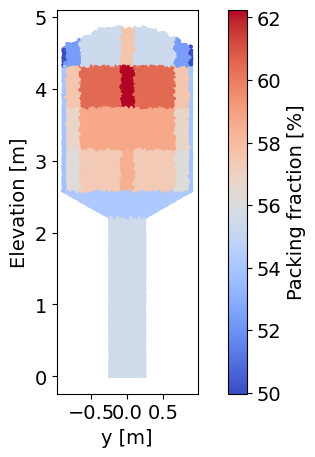

In [19]:
#### Read the alpha structure file and plot a 2D slice of the packing fraction
data_mesh['alpha'] = read_fields('./rootCase/0/fluidRegion/alpha.structure')


data_mesh_2D = data_mesh.loc[(np.abs(data_mesh['x']) < 0.03) & (data_mesh['n_peb_idx'] > -1)]
plt.scatter(data_mesh_2D['y'], data_mesh_2D['elev'], s=3, 
                      c=data_mesh_2D['alpha'] * 100, cmap='coolwarm')
plt.xlabel('y [m]')
plt.ylabel('Elevation [m]')
plt.gca().set_aspect('equal')
plt.colorbar(label='Packing fraction [%]')
plt.tight_layout()
plt.show()


In [9]:
### check convergence 
log=pd.read_csv('./steadyState/processor0/GeN-Foam.dat',sep=';',index_col=False)
plt.plot(log['time(s)'],log['TCoolant_Max'],label='max')
plt.plot(log['time(s)'],log['Avg.2'],label='avg')
plt.grid()
plt.xlabel('Simulation time [s]')
plt.xlabel('Coolant temperature [K]')
plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: './steadyState/processor0/GeN-Foam.dat'

In [14]:
#### this shell can be used to modify the alpha.structure file, using zones, pebble wise or homogeneous packing fraction 
#### write alpha.structure
def write_field_file(field_name, num_cells, field_values, file_name):
    """
    Writes an OpenFOAM field file with a user-defined field and number of cells.

    Parameters:
    field_name (str): The name of the field.
    num_cells (int): The number of cells in the field.
    field_values (list): The list of field values.
    file_name (str): The name of the output file.

    Returns:
    None
    """
    # Open the output file for writing
    with open(file_name, 'w') as f:
        # Write the header
        f.write('/*--------------------------------*- C++ -*----------------------------------*\\\n')
        f.write('| =========                 |                                                 |\n')
        f.write('| \\\\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |\n')
        f.write('|  \\\\    /   O peration     | Version:  v2012                                 |\n')
        f.write('|   \\\\  /    A nd           | Website:  www.OpenFOAM.org                      |\n')
        f.write('|    \\\\/     M anipulation  |                                                 |\n')
        f.write('\\*---------------------------------------------------------------------------*/\n')
        f.write('FoamFile\n')
        f.write('{\n')
        f.write('    version     2.0;\n')
        f.write('    format      ascii;\n')
        f.write('    class       volScalarField;\n')
        f.write('    location    "0/fluidRegion";\n')
        f.write('    object      ' + field_name + ';\n')
        f.write('}\n')
        ##### To be modiefied depending on what is the unit of your field 
        #### Power [1 -3 0 0 0 0 0]
        ##### Temperature [0 0 0 1 0 0 0]
        ##### density [1 -3 0 0 0 0 0]
        f.write('dimensions [0 0 0 0 0 0 0];\n')
        f.write('internalField   nonuniform List<scalar>\n')
        f.write(str(num_cells)+'\n')
        f.write('(\n')
        # Write the field values
        for i in range(num_cells):
            f.write(str(field_values[i]) + '\n')
        f.write(')\n')
        f.write(';\n')
        f.write('boundaryField\n')
        f.write('{\n')
        f.write('    Inlet\n')
        f.write('    {\n')
        f.write('        type            zeroGradient;\n')
        f.write('    }\n')
        f.write('    Outlet\n')
        f.write('    {\n')
        f.write('        type            zeroGradient;\n')
        f.write('    }\n')
        f.write('    Active\n')
        f.write('    {\n')
        f.write('        type            zeroGradient;\n')
        f.write('    }\n')
        f.write('    Defueling_end\n')
        f.write('    {\n')
        f.write('        type            zeroGradient;\n')
        f.write('    }\n')
        f.write('    Defueling_chute\n')
        f.write('    {\n')
        f.write('        type            zeroGradient;\n')
        f.write('    }\n')
        f.write('    Cone\n')
        f.write('    {\n')
        f.write('        type            zeroGradient;\n')
        f.write('    }\n')
        f.write('}\n')
        f.close()


def assign_PF(opt,r_zone=0,z_zone=0):
    ############################## If you want to use pebble-wise packing fraction, opt=1 #############################
    ##################################################################################################################
    
    data_core=data_mesh.loc[data_mesh['n_peb_idx']>-1]
    PF_mean_c=np.average(data_core['PF'],weights=data_core['V'])
    print(PF_mean_c)
    if opt==1:
        data_mesh['PF_OF']=data_mesh['PF']
        print(np.average(data_mesh['PF_OF'],weights=data_mesh['V']))
    
    
    
    ############################## If you want to use homogeneous packing fraction, opt=2 #############################
    ##################################################################################################################
    
    
    elif opt==2:
        data_mesh['PF_OF']=0
        data_mesh.loc[data_mesh['n_peb_idx']>-1,'PF_OF']=PF_mean_c
        print(np.average(data_mesh['PF_OF'],weights=data_mesh['V']))
    
    ############################## If you want to use homogeneous packing fraction, set 'opt=3' and choose the value of r_zone and z_zone, #############################
    ####################################################################################################################################################################
    
    else:
        data_mesh['PF_OF']=0
        if r_zone ==4:
            r_bins=[0,0.09,0.66,0.87,0.9]
        elif r_zone ==5:
            r_bins=[0,0.09,0.2,0.66,0.87,0.9]
        elif r_zone ==6:
            r_bins=[0,0.09,0.2,0.4,0.66,0.87,0.9]
        z_bins=np.linspace(-3.51818,-1.2,z_zone)
        ### take care of CONE: 
        data_extracted=data_mesh.loc[(data_mesh['z']<-3.51818)&(data_mesh['z']>-3.88764)]
        idx=data_extracted.index.values     
        data_mesh.loc[idx,'PF_OF']=np.average(data_extracted['PF'],weights=data_extracted['V'])
        print(np.average(data_extracted['PF'],weights=data_extracted['V']))
    
        ### take care of the DEF CHUTE: 
        data_extracted=data_mesh.loc[(data_mesh['z']<=-3.88764)]
        idx=data_extracted.index.values     
        data_mesh.loc[idx,'PF_OF']=np.average(data_extracted['PF'],weights=data_extracted['V'])
        print(np.average(data_extracted['PF'],weights=data_extracted['V']))
        for k in range(len(z_bins)-1):
            for i in range(len(r_bins)-1):
                data_extracted=data_mesh.loc[(r_bins[i]<=data_mesh['r_dist'])&(data_mesh['r_dist']<r_bins[i+1])&(z_bins[k]<=data_mesh['z'])&(data_mesh['z']<z_bins[k+1])]
                data_core_extracted=data_extracted.loc[data_extracted['n_peb_idx']>-1]
                if len(data_core_extracted>0):
                    idx=data_core_extracted.index.values 
                    data_mesh.loc[idx,'PF_OF']=np.average(data_core_extracted['PF'],weights=data_core_extracted['V'])
        print(np.average(data_mesh['PF_OF'],weights=data_mesh['V']))
        
    write_field_file('alpha.structure', len(data_mesh), data_mesh['PF_OF'], './rootCase/0/fluidRegion/alpha.structure')


    
            
    



In [20]:
assign_PF(1)

0.5677947158329884
0.527198389369095
